<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

# Vorlesung 6: Thema Rekursive Neuronale Netze (RNN)

## Aufgabe 1: RNN Gradient Explosion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output

# PyTorch
try:
    import torch
    import torchvision
    import torchmetrics
except:
    !pip install torch
    !pip install torchvision
    !pip install torchmetrics
    import torch
    import torchvision
    import torchmetrics

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import rgb_to_grayscale
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
# PyTorch Version überprüfen
if (torch.__version__ < "2.0.0"):
    raise Exception("Wrong PyTorch version")
else:
    print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.3.1+cpu


Nutze GPU für beschleunigtes Maschinelles Lernen

In [3]:
# Wähle Computation Device (Fallback ist "cpu")

# MPS, CUDA oder CPU
if (torch.backends.mps.is_available()):
    device = "mps"
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
elif (torch.cuda.is_available()):
    device = "cuda"
else:
    device = "cpu"

device = torch.device(device)

print(f"Using device: {device}")

Using device: cpu


### Problem der "Exploding Gradients"

Beispiele:

* https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [4]:
# Synthetischen Datensatz erzeugen mit folgender Struktur:
# [[a,b], ...]
def binary_addition(n_samples=1000, max_binary=50):
    # Generiere Feature Paare aus Zufallszahlen
    X = torch.randint(0, max_binary, (n_samples, 2), dtype=torch.float32).unsqueeze(1)
    # Bilde Summe aus Paaren und lege diese Als label fest
    Y = X.sum(dim=-1)
    return X, Y

# Erzeuge Features und Labels
X, Y = binary_addition()

# Lade Daten auf Computation Device
X = X.to(device)
Y = Y.to(device)

In [5]:
learning_rate = 0.05 # Beispiel für Exploding Gradients bei bestimmten Anfangswerten
epochs = 1000

# Dimensionen für Input, Hidden und Output Layers
input_dim  = 2  # 2 Zahlen als Input
hidden_dim = 16 # 16 Hidden Layers
output_dim = 1  # 1 Zahl (Summe) als Output

# Deklariere RNN Modell
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out


# Definiere Modell
model = SimpleRNN(input_dim, hidden_dim, output_dim)
model.to(device)

# Definiere Loss Funktion
criterion = nn.MSELoss()

# Definiere Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Model Training -> Mehrmals ausführen für Gradient Explosion!

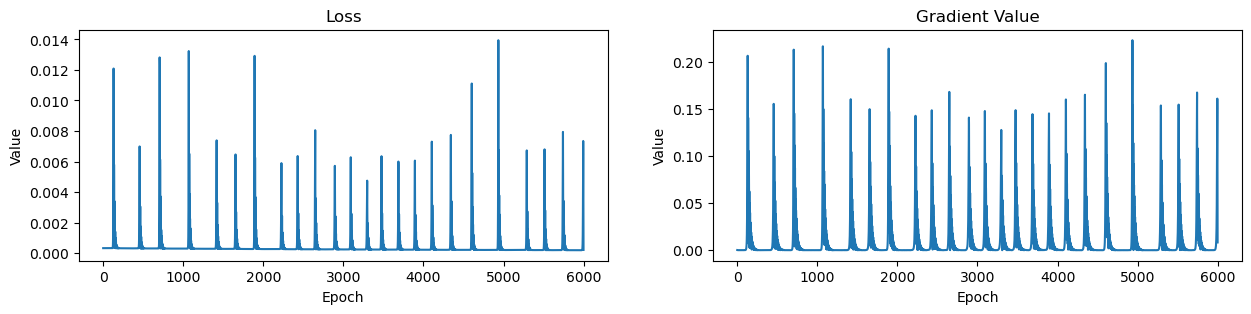

Epoch: 6000, Loss: 0.00020913347543682903, Gradients: 0.008404910564422607


In [11]:
loss_values = []
max_gradients = []

# Initiiere Modell in den Trainingsmodus (kein Training! Nur Modus setzen.)
model.train() 

# Trainiere Modell
for epoch in range(epochs):
    
    # Gradienten initialisieren
    model.zero_grad()

    # Anwendung der Features auf das Modell
    outputs = model(X)

    # Berechne loss für die aktuelle Batch
    loss = criterion(outputs.squeeze(), Y.squeeze())

    # Initiiere Optimizer Gradients auf 0
    optimizer.zero_grad()

    # Initiiere Rückwärtspropagation des Fehlers
    loss.backward()

    # Optimiere Modell
    optimizer.step()

    # Trainingsmetriken speichern
    loss_values.append(loss.item())
    max_gradients.append(model.fc.weight.grad.max())

    if (epoch+1) % 100 == 0:
        # Clear Output
        clear_output(wait=True)

        # aktuelle LR aus Adam laden?

        # Plotte Loss und Gradienten
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
        ax[0].plot(loss_values)
        ax[0].set_ylabel("Value")
        ax[0].set_xlabel("Epoch")
        ax[0].set_title("Loss")
        ax[1].plot(max_gradients)
        ax[1].set_ylabel("Value")
        ax[1].set_xlabel("Epoch")
        ax[1].set_title("Gradient Value")
        plt.show()

        print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Gradients: {model.fc.weight.grad.max()}')


        # HINWEIS: Mehrmals ausführen für Gradient Explosion!

Wann tritt das Problem auf?

Wie wir sehen verbleibt der Trainingloss beim Wert *nan* (not a number).

### Mögliche Problemlösungsstrategie

1. Verringerung der Lernrate um Divergenz zu vermeiden
2. Optimierer nutzen, der die Lernrate adaptiv verändert
3. Gradienten clipping verwenden zur Vermeidung von explodierenden Gradienten

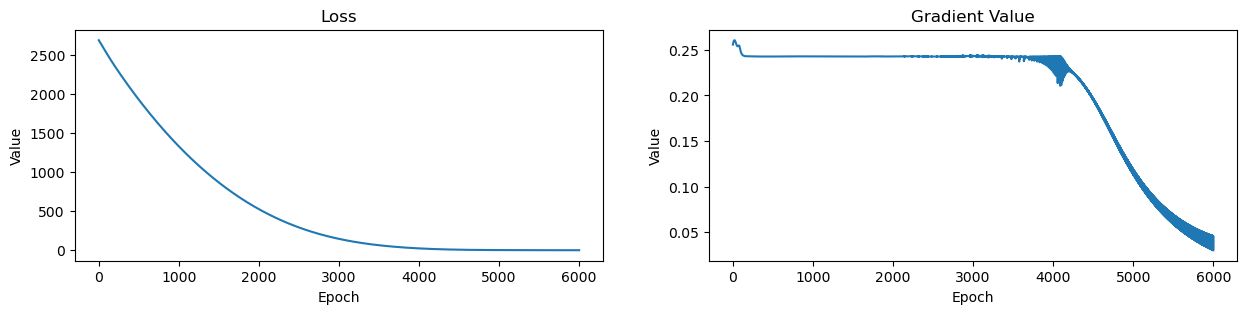

LR: 0.001
Epoch: 6000, Loss: 0.38109123706817627


In [7]:
import torch
import torch.nn as nn
import numpy as np

# We set a reasonable learning rate
learning_rate = 0.001
epochs = 6000

# Dimensions for input, hidden and output layers
input_dim = 2
hidden_dim = 16
output_dim = 1

# Define the model
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Define loss function and optimizer
model = SimpleRNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Switch to an optimizer that adaptively adjusts learning rates

# Binary addition dataset
def binary_addition(n_samples=1000, max_binary=50):
    X = torch.randint(0, max_binary, (n_samples, 2), dtype=torch.float32).unsqueeze(1)
    Y = X.sum(dim=-1)
    return X, Y

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Prepare data
X, Y = binary_addition()

# To save the loss value at each epoch
loss_values = []
max_gradients = []

# Load data to GPU
model.to(device)
X = X.to(device)
Y = Y.to(device)

# Train the model
for epoch in range(epochs):

    # Optimization to reduce zero-ing out by setting to None instead
    # model.zero_grad()
    for param in model.parameters():
        param.grad = None

    outputs = model(X)
    loss = criterion(outputs.squeeze(), Y.squeeze())
    loss.backward()
    # Werte "abschneiden" falls zu groß
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()

    loss_values.append(loss.item())
    max_gradients.append(model.fc.weight.grad.max())
    
    if (epoch+1) % 100 == 0:
        # Clear the output and display the updating plot
        clear_output(wait=True)

        # Plotte Loss und Gradienten
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
        ax[0].plot(loss_values)
        ax[0].set_ylabel("Value")
        ax[0].set_xlabel("Epoch")
        ax[0].set_title("Loss")
        ax[1].plot(max_gradients)
        ax[1].set_ylabel("Value")
        ax[1].set_xlabel("Epoch")
        ax[1].set_title("Gradient Value")
        plt.show()

        # aktuelle LR aus Adam laden?
        print(f'LR: {get_lr(optimizer)}')
        
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')


Problem: Trotz Verbesserung stellt sich nach einigen Epochen ein Stillstand in der Performanz des Modells ein.